Возьмите задачу с винами (www.kaggle.com...ne-quality) и решите ее, оформив в виде CrispDM-подхода. Решение - jupyter notebook на github или colab.
! Только для тех у кого уже диплом ! Оформите задачи по дипломной работе в виде этапов CrispDM (например, в trello). Пришлите скриншот.

# 1. Понимание бизнеса



## 1.1 Цель
Предсказать качество вина

## 1.2 Описание от kaggle
Информация о Наборе данных:
Набор данных был загружен из репозитория машинного обучения UCI.
Эти два набора данных относятся к красному и белому вариантам португальского вина "Винью Верде".
Ссылка [Кортес и др., 2009]. Из-за проблем конфиденциальности и логистики доступны только физико-химические
(входные данные) и сенсорные (выходные данные) переменные (например, нет данных о сортах винограда, марке вина,
цене продажи вина и т.д.).
Эти наборы данных можно рассматривать как задачи классификации или регрессии.
Классы упорядочены и не сбалансированы (например, есть гораздо больше нормальных вин, чем отличных или плохих). 
Алгоритмы обнаружения выбросов могут быть использованы для обнаружения нескольких превосходных или плохих вин.
Кроме того, мы не уверены, что все входные переменные являются релевантными. 
Так что было бы интересно протестировать методы выбора функций.

Два набора данных были объединены, и несколько значений были удалены случайным образом.



# 2. Data Understanding

## 2.1 Import Libraries

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [4]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    print (model.score( X , y ))
    

## 2.3 Загрузка данных

In [5]:
data = pd.read_csv('winequalityN.csv',sep=',')
data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [9]:
data_10 = data[["type", "volatile acidity", "chlorides", "density", "alcohol", "quality"]]

In [11]:
data_10.head(20)

,type,volatile acidity,chlorides,density,alcohol,quality
0,white,0.27,0.045,1.0010,8.8,6
1,white,0.30,0.049,0.9940,9.5,6
2,white,0.28,0.050,0.9951,10.1,6
3,white,0.23,0.058,0.9956,9.9,6
4,white,0.23,0.058,0.9956,9.9,6
5,white,0.28,0.050,0.9951,10.1,6
6,white,0.32,0.045,0.9949,9.6,6
7,white,0.27,0.045,1.0010,8.8,6
8,white,0.30,0.049,0.9940,9.5,6
9,white,0.22,0.044,0.9938,11.0,6


Информация об Атрибутах:

Для получения дополнительной информации прочитайте [Cortez et al., 2009].
Входные переменные (на основе физико-химических тестов):
1 - фиксированная кислотность
2 - летучая кислотность
3-лимонная кислота
4 - остаточный сахар
5-хлориды
6 - свободный диоксид серы
7 - общий диоксид серы
8 - плотность
9 - рН
10 - сульфаты
11 - алкоголь
Выходная переменная (на основе сенсорных данных):
12 - качество (оценка от 0 до 10)

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [226]:

data.shape

(6497, 13)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных


Числовая переменная - это переменная со значениями в области целых или действительных чисел, в то время как категориальная переменная - это переменная, которая может принимать одно из ограниченного и обычно фиксированного числа возможных значений, таких как тип вина.

Обратите особое внимание на тип каждой переменной, количество наблюдений и некоторые значения переменных.



In [227]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [228]:
data.isnull().sum()  #количество значений со значением 0

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [229]:
data.describe(include='all')

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,white,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,4898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,NaN,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,NaN,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,NaN,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,NaN,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,NaN,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000


максимальные значения наблюдаются в трех столбцах "residual sugar, free sulfur dioxide, total sulfur dioxide", это вбросы, возможно они сильно влиют на показания качества продукта.

### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны


<AxesSubplot:>

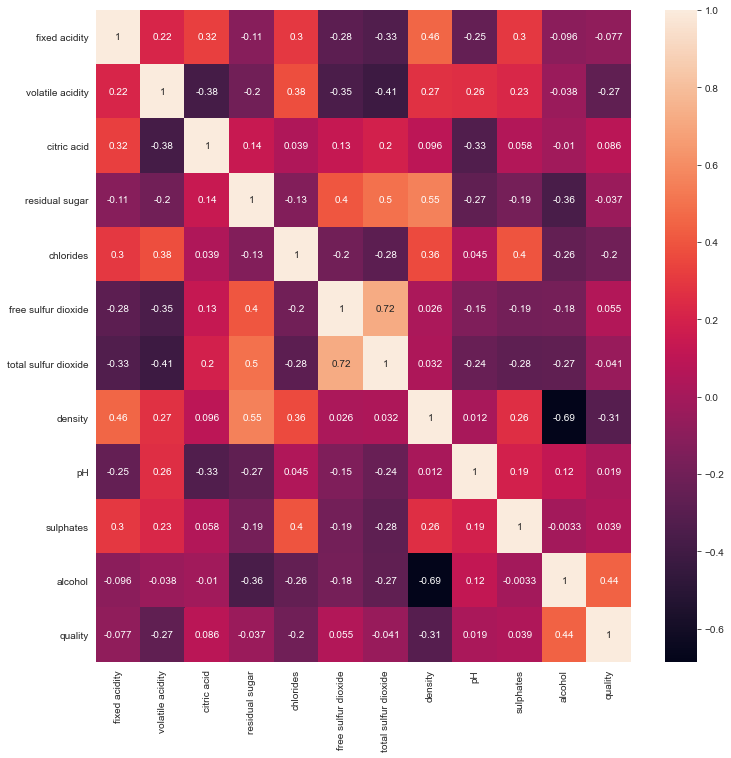

In [230]:

plt.figure(figsize=[12,12])
sns.heatmap(data.corr(), annot=True)

Наибольшая корреляция происходит между целевой переменной  и переменными alcohol - алкоголь, density - плотность, chlorides -  хлориды, volatile acidity - летучая кислотность

# 2.4.3 Понимание целевой переменной

In [231]:
data.quality.unique() # Определяем уникальные значения 

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

In [232]:
data.quality.value_counts()  # Определяем количество значений по каждому уникальному значению

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Наибельшее значение оценок качества находится в среднем диапазоне от 5 до 7,наименьшее количество выставленных оценок находится на уровне оценки 3 и на уровне оценки 9.
Оценка 10 не выставленна ни одному образцу вина , также нет ни одной оценки ниже 3.

# 2.4.4 Рассмотрим взаимосвязь между целевым признаком, типом вина и плотностью.

In [233]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 6 , df[ var ].max() ) )
    facet.add_legend()
    

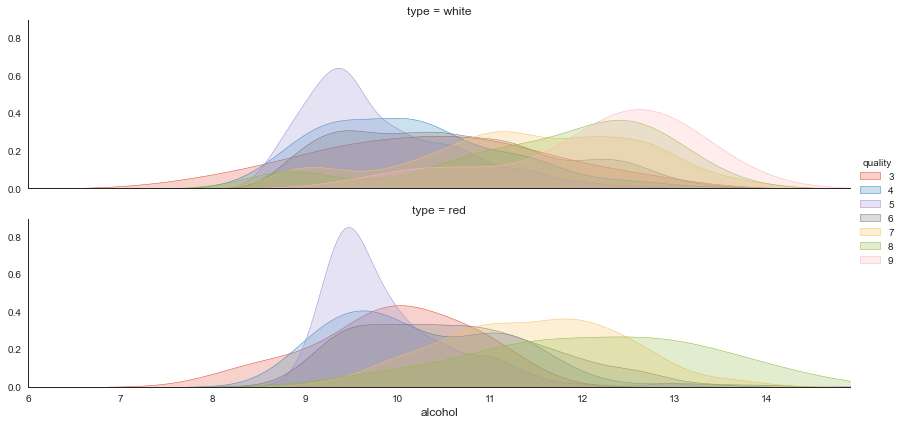

In [234]:
plot_distribution( data , var = 'alcohol' , target = 'quality' , row = 'type' )

# 2.4.5 Рассмотрим взаимосвязь между целевым признаком, типом вина и плотностью.

In [235]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0.95, df[ var ].max() ) )
    facet.add_legend()
    

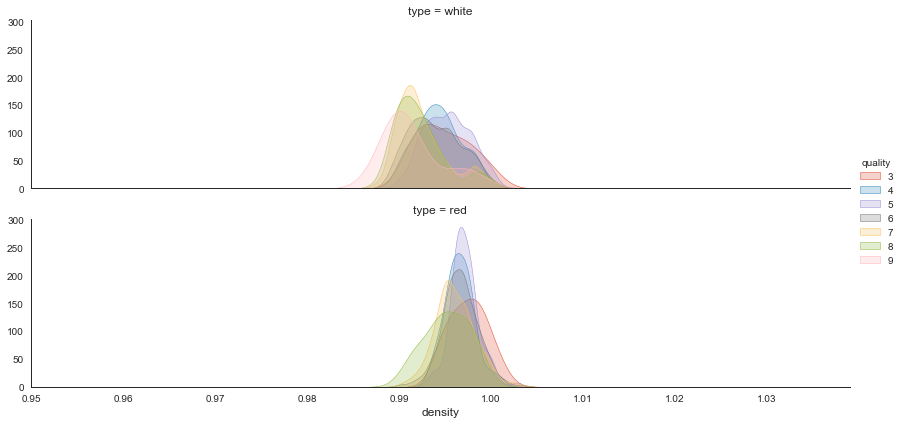

In [236]:
plot_distribution( data , var = 'density' , target = 'quality' , row = 'type' )

# 2.4.6 Рассмотрим взаимосвязь между целевым признаком, типом вина и хлоридами.

In [237]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0.0000001, df[ var ].max() ) )
    facet.add_legend()

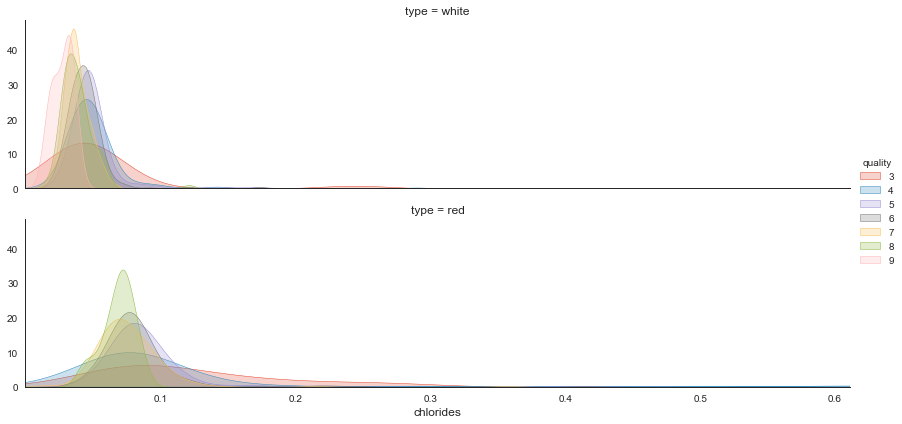

In [238]:
plot_distribution( data , var = 'chlorides' , target = 'quality' , row = 'type' )

# 2.4.7 Рассмотрим взаимосвязь между целевым признаком, типом вина и летучей кислотностью.

In [239]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0.0000001, df[ var ].max() ) )
    facet.add_legend()

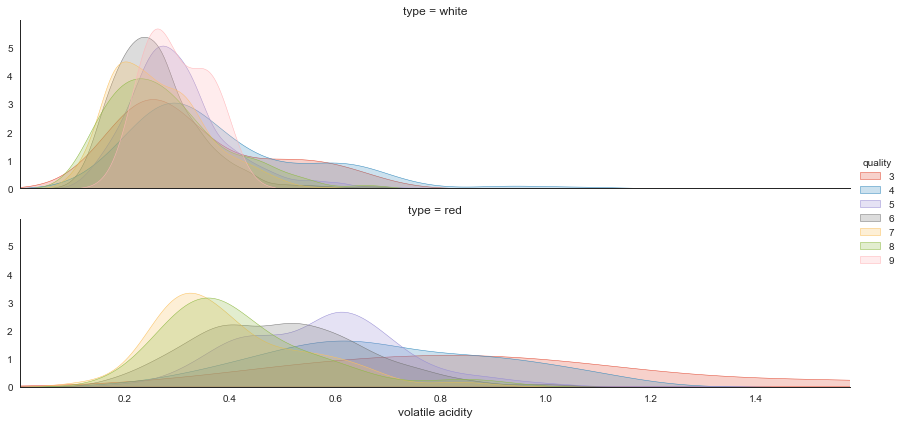

In [240]:
plot_distribution( data , var = 'volatile acidity' , target = 'quality' , row = 'type' )

# 3. Data Preparation (Подготовка данных)

# 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

Переменная "type" - категориальная переменная. Некоторые из алгоритмов могут обрабатывать только числовые значения, поэтому нам нужно создать новую (фиктивную) переменную для каждого уникального значения категориальных переменных (OneHotEncoding)

In [241]:
type_wine = pd.get_dummies( data.type , prefix='Type_wine' )
type_wine.head()

,Type_wine_red,Type_wine_white
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [242]:
data_1 = data.iloc[:,1:]
data_1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [243]:
data_1 = type_wine.join(data_1)
data_1.head()

,Type_wine_red,Type_wine_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [244]:
quality_wine = pd.get_dummies( data.quality , prefix='Type_wine' )
quality_wine.head()

,Type_wine_3,Type_wine_4,Type_wine_5,Type_wine_6,Type_wine_7,Type_wine_8,Type_wine_9
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0


In [245]:
data_1 = data_1.join(quality_wine)
data_1.drop(['quality'], axis = 1, inplace = True)
data_1.head()

,Type_wine_red,Type_wine_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type_wine_3,Type_wine_4,Type_wine_5,Type_wine_6,Type_wine_7,Type_wine_8,Type_wine_9
0,0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0,0,0,1,0,0,0
1,0,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0,0,0,1,0,0,0
2,0,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,0,0,1,0,0,0
3,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,0,1,0,0,0
4,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0,0,0,1,0,0,0


# 3.2 Заполнить пропущенные значения в переменных

Большинство алгоритмов машинного обучения требуют, чтобы все переменные имели значения, чтобы использовать их для обучения модели. Самый простой метод - заполнить пропущенные значения средним по переменной для всех наблюдений в обучающем наборе.Но мы заполним медианой.

In [246]:
#Замена всех выброшенных значений средними значениями
#Среднее теперь не учитывает те самые выброшенные значения
for i in data_1.columns:
    data_1[i]=data_1[i].fillna(data_1[i].median())

In [247]:
data_1.isnull().sum()

Type_wine_red           0
Type_wine_white         0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Type_wine_3             0
Type_wine_4             0
Type_wine_5             0
Type_wine_6             0
Type_wine_7             0
Type_wine_8             0
Type_wine_9             0
dtype: int64

# 3.3 Дропаем дубликаты

In [248]:
data_1.shape

(6497, 20)

In [249]:
data_1 = data_1.drop_duplicates()
data_1

,Type_wine_red,Type_wine_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type_wine_3,Type_wine_4,Type_wine_5,Type_wine_6,Type_wine_7,Type_wine_8,Type_wine_9
0,0,1,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,0,0,0,1,0,0,0
1,0,1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,0,0,0,1,0,0,0
2,0,1,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,0,0,0,1,0,0,0
3,0,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0,0,0,1,0,0,0
6,0,1,6.2,0.320,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6491,1,0,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,0,0,0,1,0,0,0
6492,1,0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,0,0,1,0,0,0,0
6493,1,0,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.51,11.2,0,0,0,1,0,0,0
6495,1,0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,0,0,1,0,0,0,0


# 3.4 Нормализуем параметры

In [250]:
headers = list(data_1.columns.values)

In [251]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))

d = min_max_scaler.fit_transform(data_1)
scaled_df_nor = pd.DataFrame(d,columns=headers )
scaled_df_nor.head()


# from sklearn import preprocessing
# d = preprocessing.normalize(data_1) 
# scaled_df_nor = pd.DataFrame(d, columns=headers)
# scaled_df_nor.head()



,Type_wine_red,Type_wine_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type_wine_3,Type_wine_4,Type_wine_5,Type_wine_6,Type_wine_7,Type_wine_8,Type_wine_9
0,-1.0,1.0,-0.471074,-0.746667,-0.566265,-0.383436,-0.880399,-0.694444,-0.244240,-0.464430,-0.565891,-0.741573,-0.768116,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
1,-1.0,1.0,-0.586777,-0.706667,-0.590361,-0.969325,-0.867110,-0.909722,-0.419355,-0.734336,-0.100775,-0.696629,-0.565217,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,-1.0,1.0,-0.289256,-0.733333,-0.518072,-0.806748,-0.863787,-0.798611,-0.580645,-0.691922,-0.162791,-0.752809,-0.391304,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
3,-1.0,1.0,-0.438017,-0.800000,-0.614458,-0.757669,-0.837209,-0.680556,-0.170507,-0.672643,-0.271318,-0.797753,-0.449275,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-1.0,1.0,-0.603306,-0.680000,-0.807229,-0.803681,-0.880399,-0.798611,-0.400922,-0.699634,-0.286822,-0.719101,-0.536232,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0


# 3.6 Feature Engineering – добавляем новые признаки

Добавлять новые признаки не будем

# 3.7 Сборка финальных датасетов для моделирования

# 3.7.1 Variable selection
Выбираем признаки для формирования итогового датасет. У нас доступны признаки:


type
1 - fixed acidity (фиксированная кислотность)
2 - volatile acidity (летучая кислотность)
3 - citric acid (лимонная кислота)
4 - residual sugar (остаточный сахар)
5 - chlorides (хлориды)
6 - free sulfur dioxide (свободный диоксид серы)
7 - total sulfur dioxide (общий диоксид серы)
8 - density (плотность)
9 - pH (водородный показатель)
10 - sulphates (сульфаты)
11 - alcohol (алкоголь)
Выходная переменная (на основе сенсорных данных):
12 - quality (score between 0 and 10) качество (оценка от 0 до 10 баллов)

Все признаки оставляем

In [253]:
scaled_df_nor.sample(10)

,Type_wine_red,Type_wine_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Type_wine_3,Type_wine_4,Type_wine_5,Type_wine_6,Type_wine_7,Type_wine_8,Type_wine_9
3009,-1.0,1.0,-0.752066,-0.706667,-0.638554,-0.981595,-0.933555,-0.833333,-0.599078,-0.988047,-0.085271,-0.797753,0.623188,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
4298,1.0,-1.0,0.685950,-0.560000,-0.240964,-0.901840,-0.734219,-0.965278,-0.811060,-0.449007,-0.550388,-0.337079,-0.188406,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
1448,-1.0,1.0,-0.570248,-0.786667,-0.734940,-0.972393,-0.903654,-0.743056,-0.304147,-0.757471,0.069767,-0.629213,-0.449275,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
976,-1.0,1.0,-0.090909,-0.653333,-0.409639,-0.794479,-0.857143,-0.798611,-0.354839,-0.580104,-0.302326,-0.561798,-0.362319,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
2084,-1.0,1.0,-0.504132,-0.826667,-0.566265,-0.463190,-0.877076,-0.784722,-0.414747,-0.502988,-0.147287,-0.707865,-0.768116,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
4876,1.0,-1.0,-0.272727,-0.120000,-0.891566,-0.957055,-0.807309,-0.972222,-0.981567,-0.727395,-0.131783,-0.606742,0.101449,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
3983,1.0,-1.0,-0.157025,-0.280000,-0.771084,-0.898773,-0.465116,-0.652778,-0.345622,-0.556969,-0.302326,-0.202247,-0.652174,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
2588,-1.0,1.0,-0.652893,-0.666667,-0.614458,-0.769939,-0.903654,-0.944444,-0.870968,-0.846154,-0.224806,-0.842697,0.362319,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0
1324,-1.0,1.0,-0.338843,-0.706667,-0.108434,-0.963190,-0.920266,-0.777778,-0.308756,-0.850010,-0.116279,-0.662921,0.391304,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
153,-1.0,1.0,-0.636364,-0.213333,-0.915663,-0.981595,-0.830565,-0.944444,-0.529954,-0.769038,-0.395349,-0.853933,-0.797101,-1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# 3.7.2 Создание датасетов

In [254]:
scaled_df_nor.iloc[:,13:]

,Type_wine_3,Type_wine_4,Type_wine_5,Type_wine_6,Type_wine_7,Type_wine_8,Type_wine_9
0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...
5324,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
5325,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
5326,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
5327,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0


In [281]:
y = scaled_df_nor.iloc[:,13:]
X = scaled_df_nor.iloc[:,0:13]

In [282]:
# Create all datasets that are necessary to train, validate and test models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# 3.7.3 Важность признаков

1.0
1.0


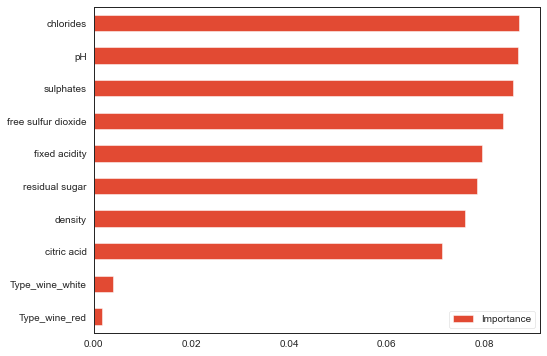

In [283]:
plot_variable_importance(X_train, y_train)

# 4. Моделирование


Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

# 4.1 Выбор модели


Хорошей отправной точкой является случайный лес

In [292]:
from sklearn.ensemble import RandomForestClassifier

In [293]:
model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=20, max_features=0.8, n_jobs=-1, bootstrap=True)

In [294]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, max_features=0.8, min_samples_leaf=20,
                       n_jobs=-1)

In [295]:
print('Вес наиболее важного признака: ', max(model.feature_importances_))
model.feature_importances_

Вес наиболее важного признака:  0.310828261701792


array([0.00041142, 0.00033775, 0.03381768, 0.14677683, 0.04867767,
       0.05945025, 0.05555652, 0.0746129 , 0.05856457, 0.08433259,
       0.04748656, 0.07914701, 0.31082826])

In [289]:
# get_score(X, y)

# 5. Evaluation (Оценка результата)

Теперь мы собираемся оценить модель

# 5.1 Модель

Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)


In [296]:
model.score(X_train, y_train)

0.5128686327077748

In [298]:
# Score the model
print (model.score(X_train, y_train ) , model.score( X_test ,  y_test ))

0.5128686327077748 0.4002501563477173


# 6. Deployment (Внедрение (Развертывание))

Точность модели низкая, перед внедрением необхолима доработка